# House prices

Load data and packages

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style='darkgrid', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Load datasets train and test

In [113]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [114]:
# Check datasets size
print(f"Train data size before drop Id column : {train.shape}")
print(f"Test data size before drop Id column : {test.shape}")

# Save column Id
train_id = train['Id']
test_id = test['Id']

Train data size before drop Id column : (1460, 81)
Test data size before drop Id column : (1459, 80)


In [115]:
# Drop column Id because it's useless for the process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check datasets size after drop Id values
print(f"Train data size after drop Id column : {train.shape}")
print(f"Test data size after drop Id column : {test.shape}")

Train data size after drop Id column : (1460, 80)
Test data size after drop Id column : (1459, 79)


In [116]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [117]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Analyze target "SalePrice"

In [118]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Visualization

Text(0.5, 1.0, 'SalePrice distribution')

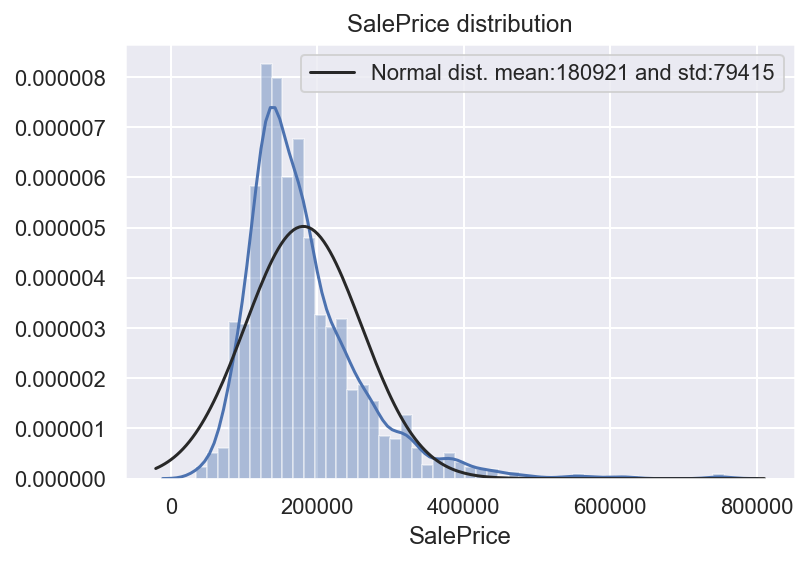

In [119]:
sns.distplot(train['SalePrice'], fit = norm)
(mean, std) = norm.fit(train['SalePrice'])
plt.legend([f"Normal dist. mean:{int(mean)} and std:{int(std)}"])
plt.title('SalePrice distribution')

In [120]:
skew_train = train['SalePrice'].skew()
kurt_train = train['SalePrice'].kurt()

print(f"Skewness: {skew_train}")
print(f"Kurtosis: {kurt_train}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


The skewness and the kurtosis show that the sale prices deviate from the normal distribution and that there is a peak.  
We want our data to be as normal as possible so we will try to fix this.

## Mutivariable analysis

We will split all features in two types :  
* Categorical
* Numerical

In [121]:
# Check categorical features
train.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [122]:
# Check numerical features
train.select_dtypes(include = ['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [123]:
# Count features by type
total_cat = len(train.select_dtypes(include = ['object']).columns)
total_num = len(train.select_dtypes(include = ['int64', 'float64']).columns)

print(f"{total_cat} categorical + {total_num} numerical = {total_cat + total_num} features")

43 categorical + 37 numerical = 80 features


### Correlation matrix heatmap

In [124]:
corrmat = train.corr()

In [125]:
corrmat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


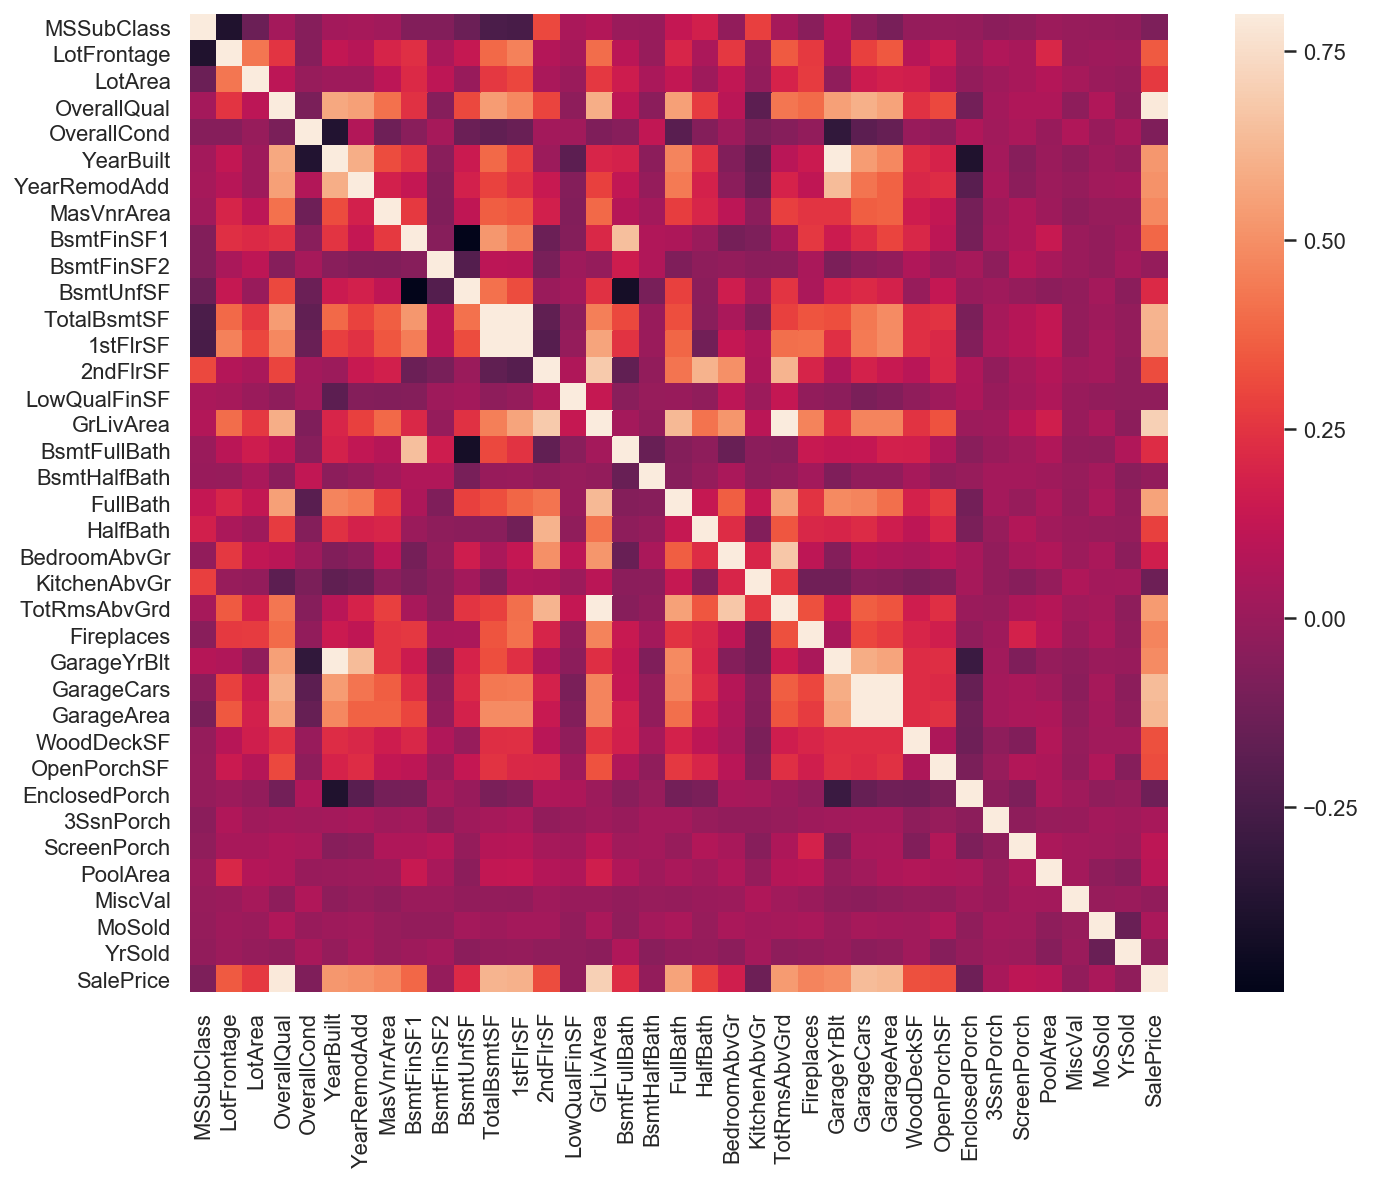

In [126]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)

Another Correlation Matrix with Top 10  features most related to Sale Price

In [127]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [128]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [129]:
# Display correlation coeff
top_10_corrmat = train[cols].corr()

In [130]:
top_10_corrmat.columns[1]

'OverallQual'

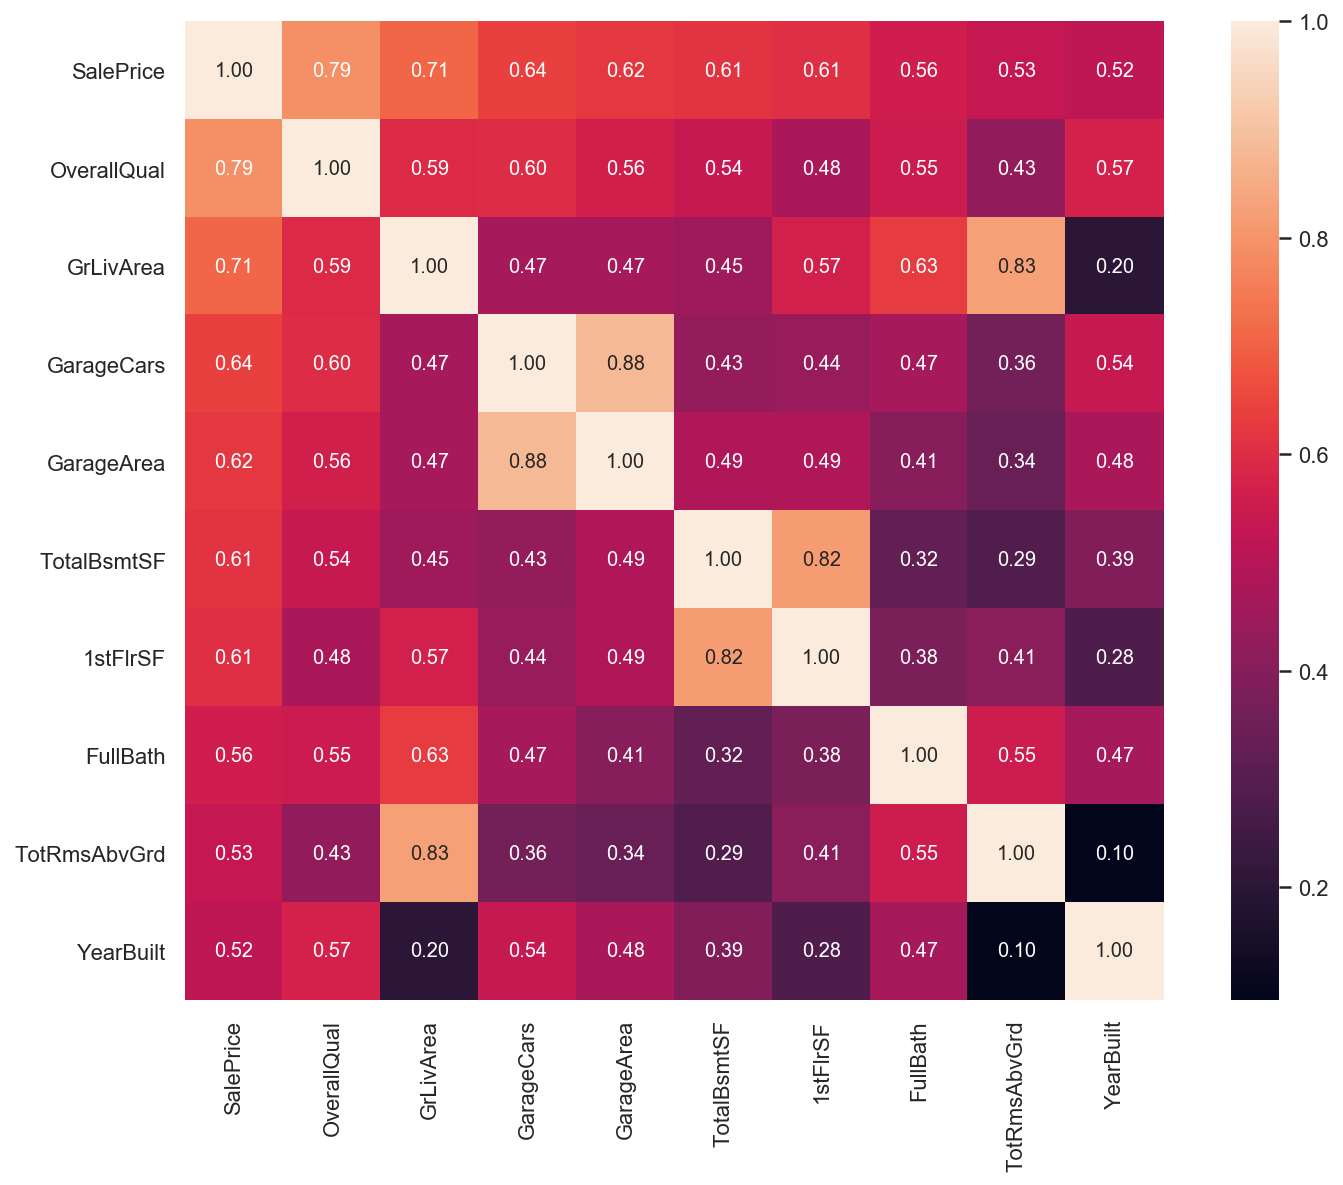

In [131]:
f, ax = plt.subplots(figsize = (12, 9))
top_10_heatmap = sns.heatmap(top_10_corrmat, 
                             annot = True, 
                             square = True, 
                             fmt = '.2f', 
                             annot_kws = {'size': 10},
                             yticklabels = cols.values,
                             xticklabels = cols.values
                            )

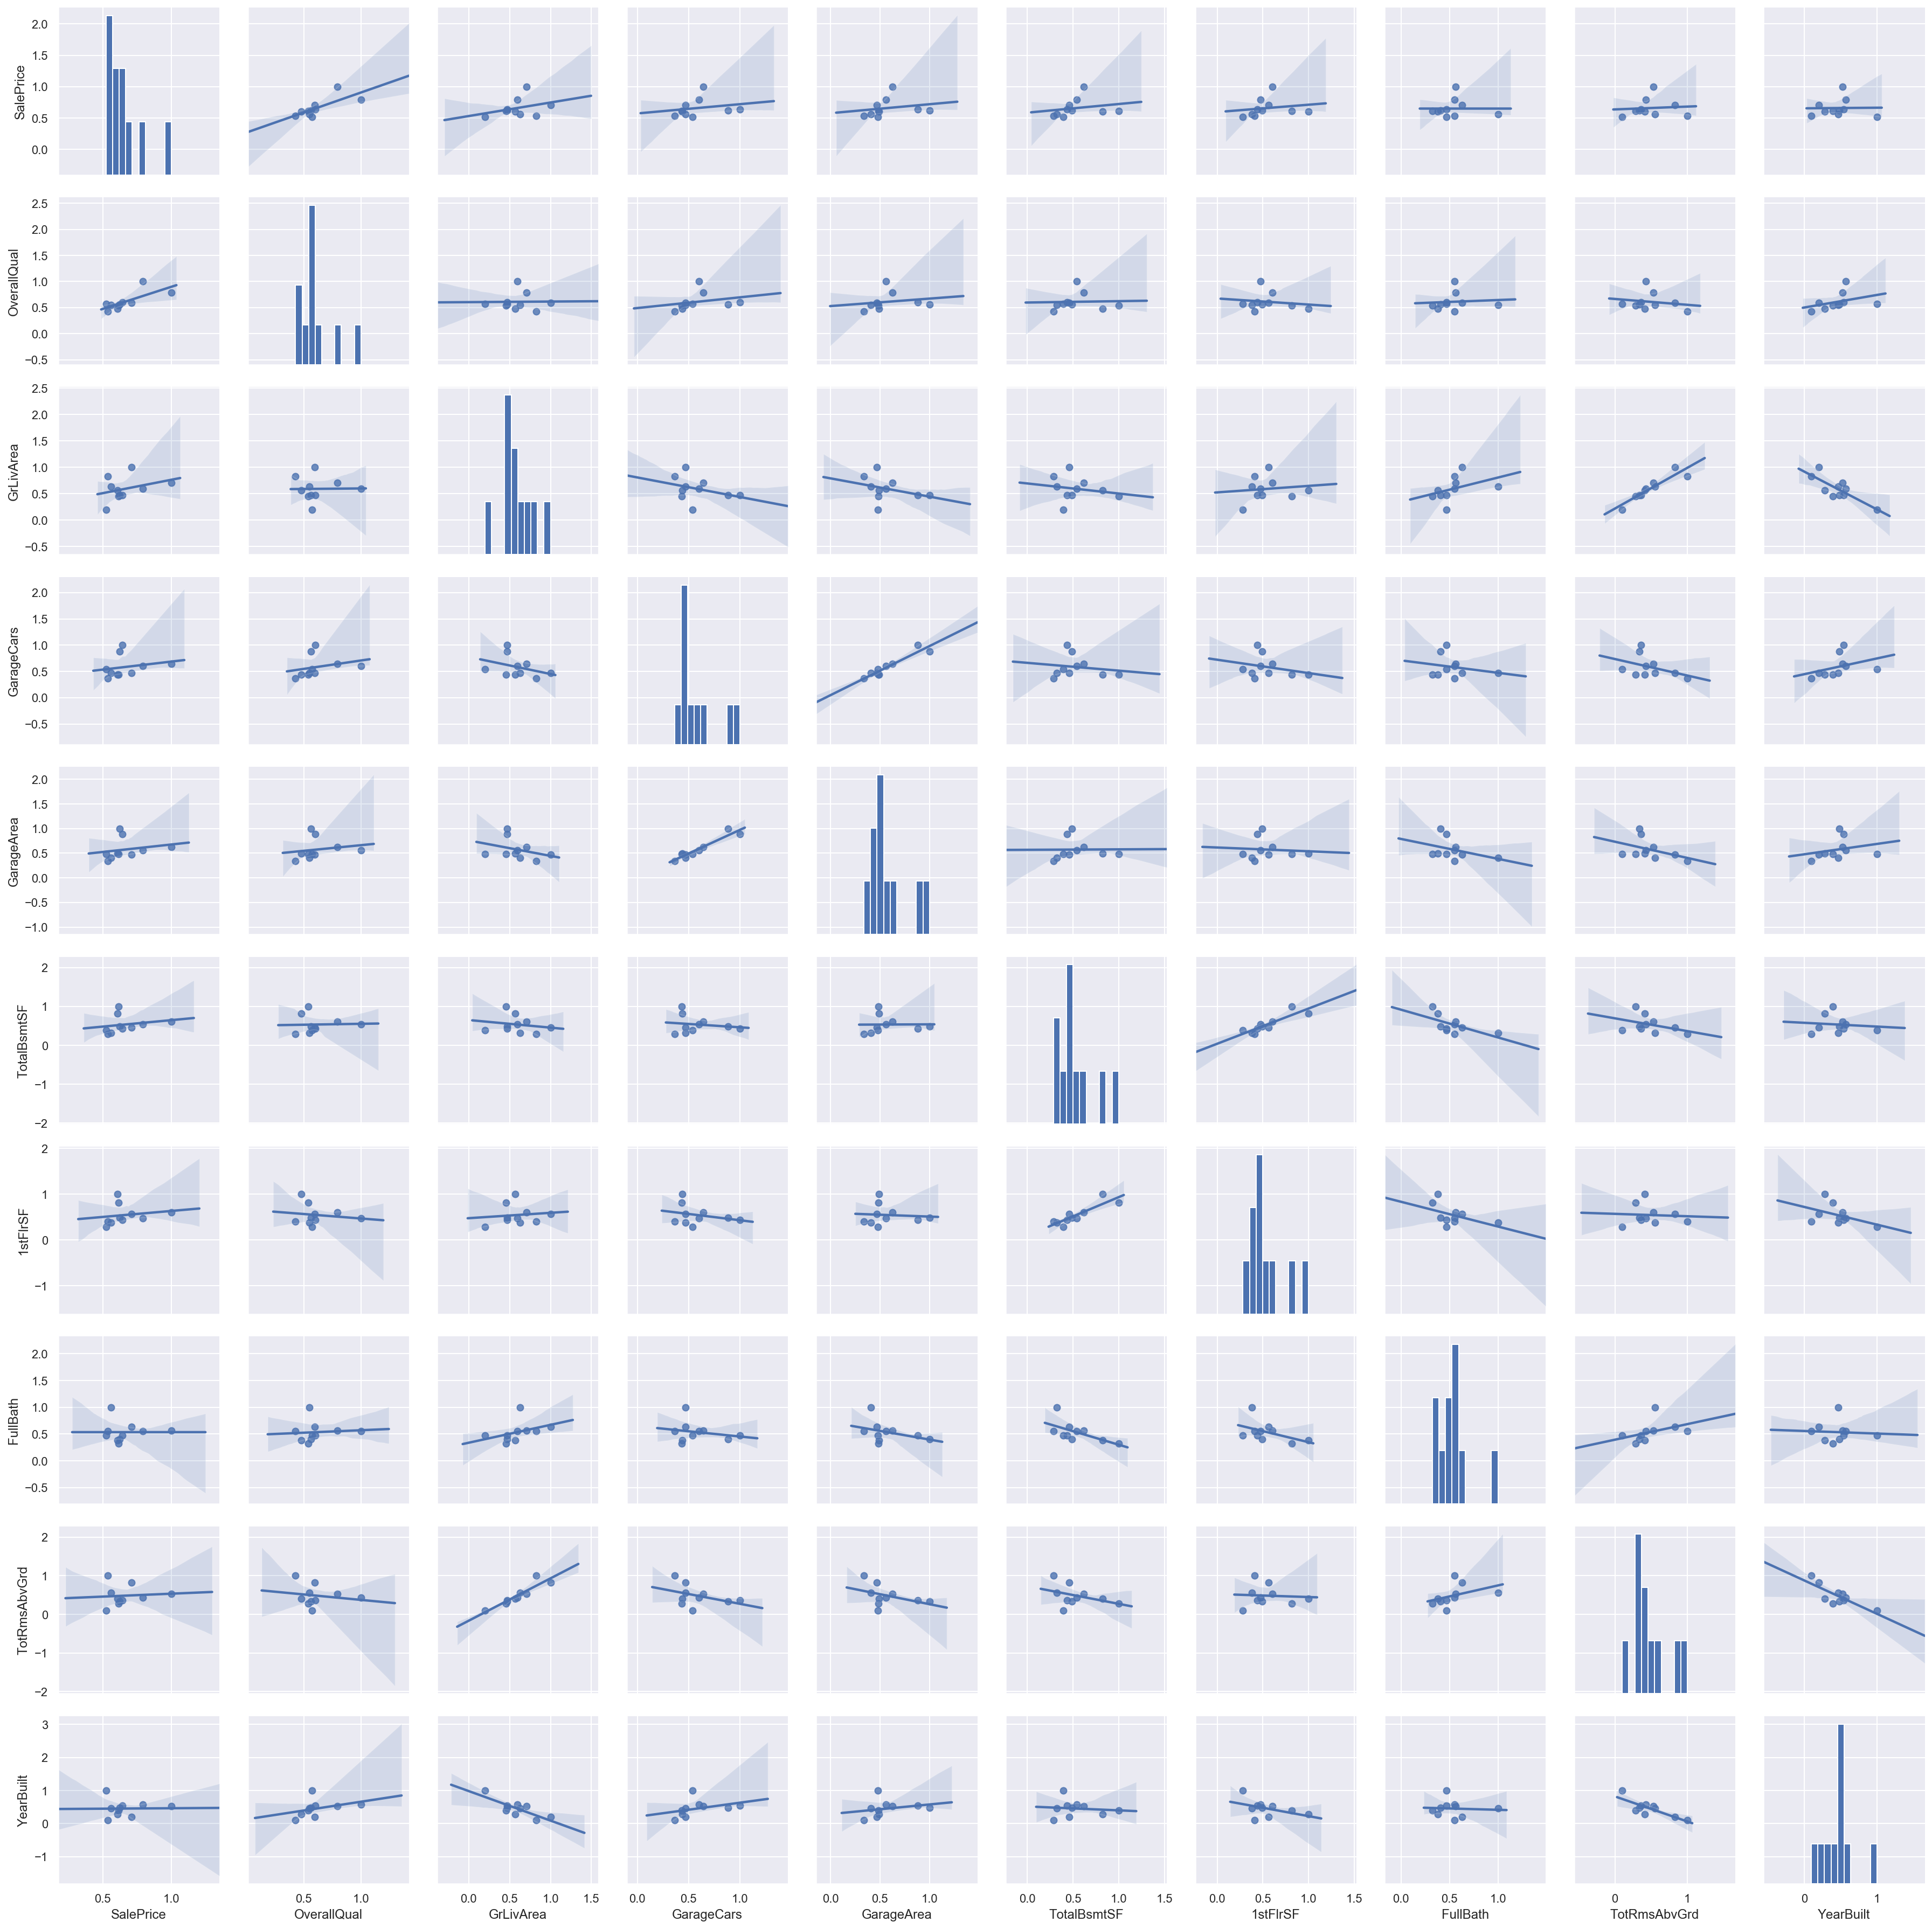

In [132]:
sns.pairplot(top_10_corrmat, kind="reg")
plt.show()

We create a dataframe of top 10 features most correlated to Sale Price

In [133]:
top_10_corrdf = pd.DataFrame(cols)
top_10_corrdf.columns = ['Most correlated Features']
top_10_corrdf

,Most correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


Let's compare each most correlated features with Sale Price

In [134]:
# OverallQual vs SalePrice

data = pd.concat([train['SalePrice'], train['OverallQual']], axis = 1)
data

,SalePrice,OverallQual
0,208500,7
1,181500,6
2,223500,7
3,140000,7
4,250000,8
...,...,...
1455,175000,6
1456,210000,6
1457,266500,7
1458,142125,5


For integer type features we will use boxplot  
For float type features we will use scatterplot with linear reg

#### OverallQual

(-0.5, 9.5, -1105.0, 800000)

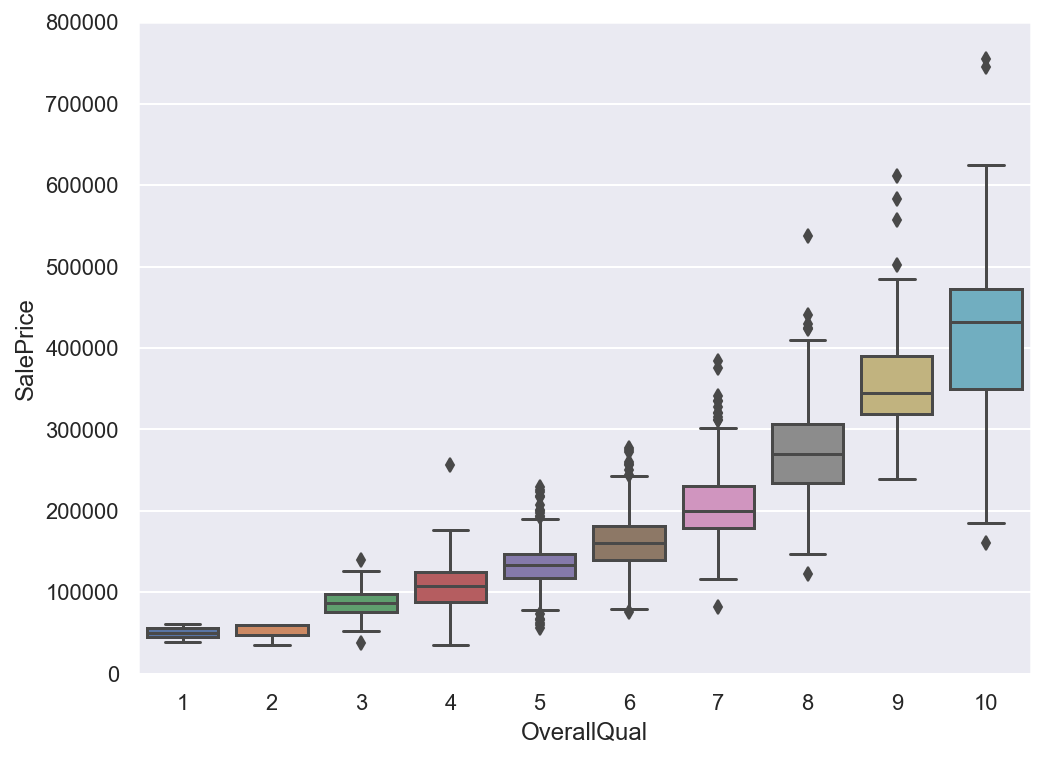

In [135]:
# Boxplot
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymax=800000)

#### GrLivArea

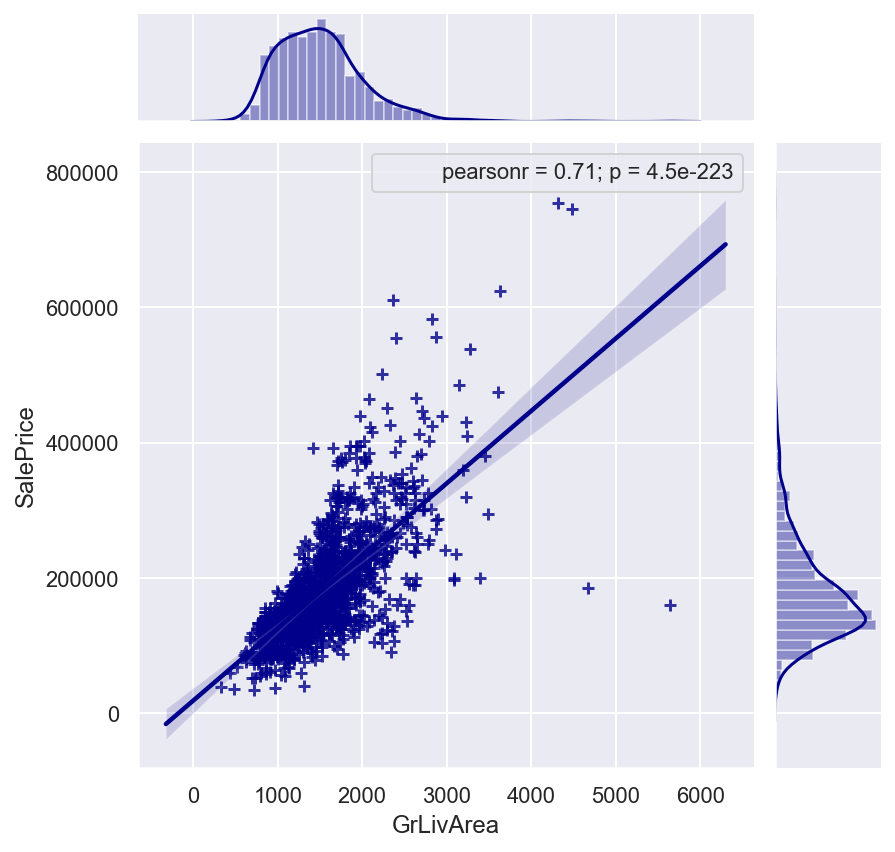

In [136]:
sns.jointplot(x = train['GrLivArea'], 
              y = train['SalePrice'], 
              kind = 'reg',
              marker = "+", 
              color = "darkblue").annotate(pearsonr)

We can observe that for a larger GrLivArea the Sale Price increase which seems logical.  
We also see two outliers where the GrLivArea is very large but the price is low.  
Let's try to remove those two values.

In [137]:
# Remove outliers (two points where GrLivArea > 4000 and SalePrice < 200 000)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index).reset_index(drop=True)

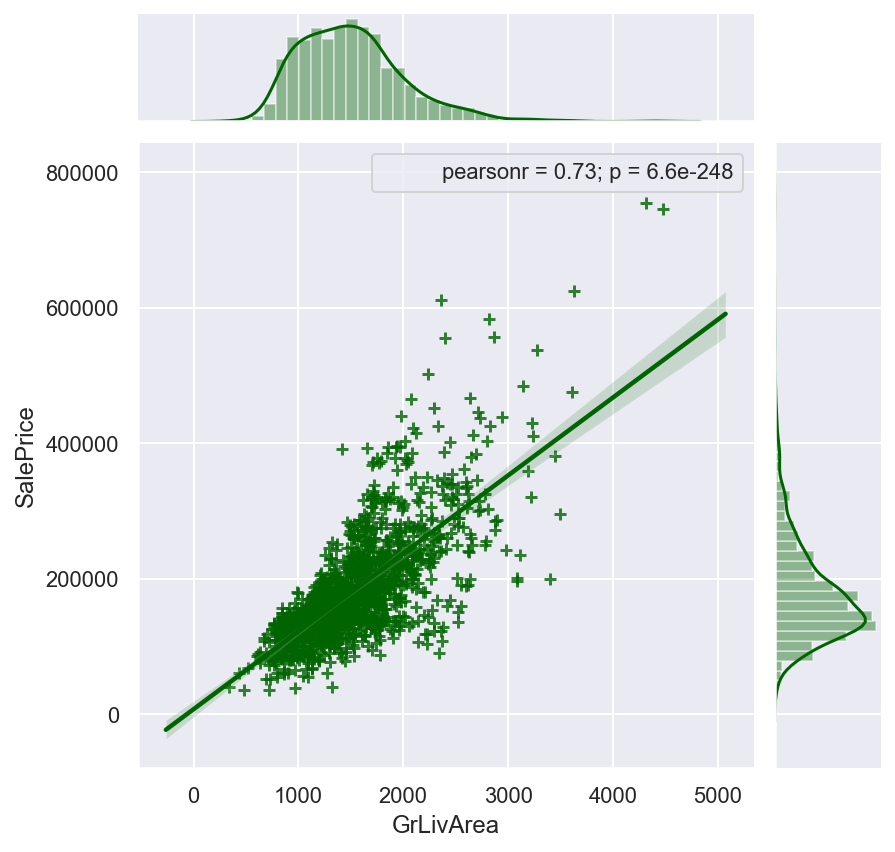

In [138]:
sns.jointplot(x = train['GrLivArea'], 
              y = train['SalePrice'], 
              kind = 'reg',
              marker = "+", 
              color = "darkgreen").annotate(pearsonr)

The correlation coefficient increases by 0.02 after removing outliers values

#### GarageCars 

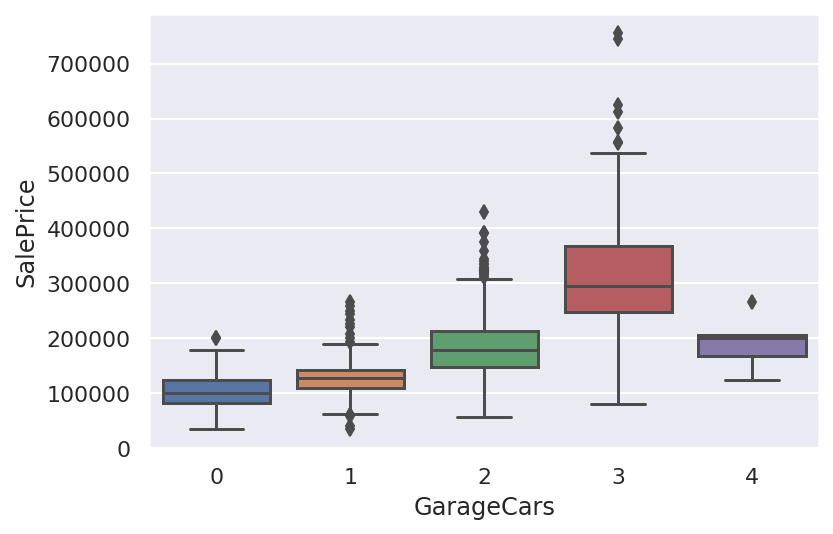

In [167]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

We can observe the more cars you can park in your garage, the more the Sale Price is high.
After more than 3 places available in the garage, the Sale Price decrease which is not logical. So we will remove the outlier values were garageCars > 3 and SalePrice < 300 000

In [168]:
# Remove outliers (where GarageCars > 3 and SalePrice < 300 000)
train = train.drop(train[(train['GarageCars'] > 3) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

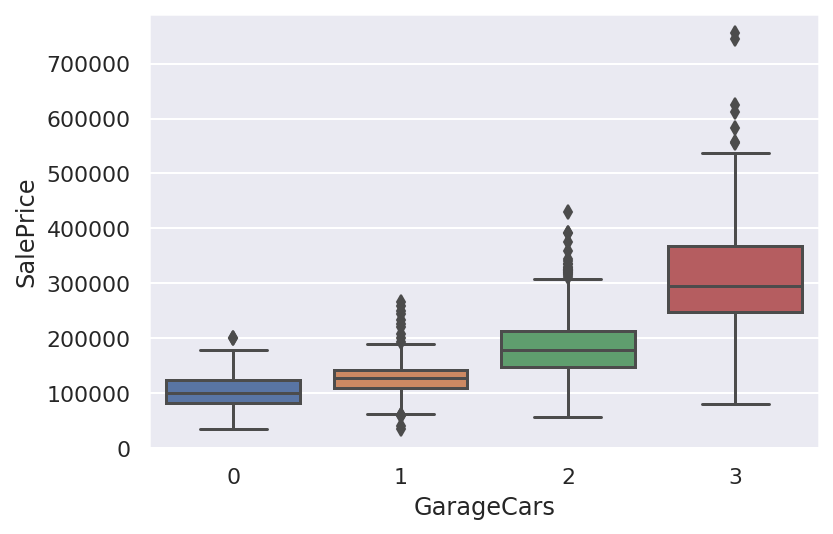

In [169]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

#### GarageArea 

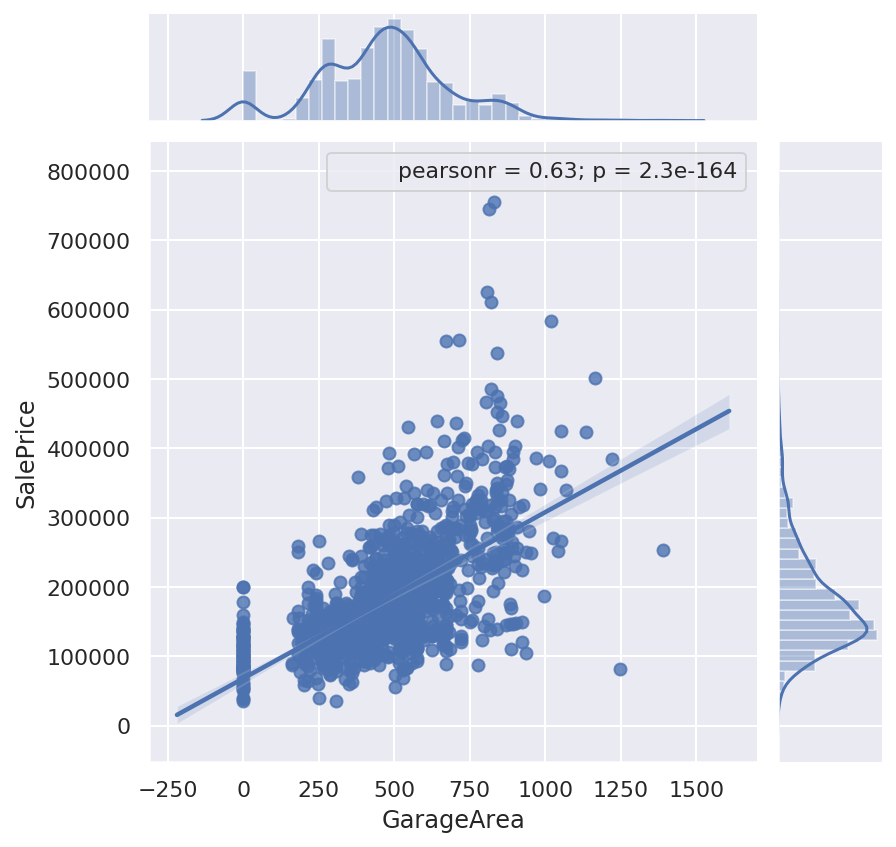

In [170]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

Two outliers (GarageArea > 1200 and SalePrice < 300000)  
Let's remove this

In [171]:
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

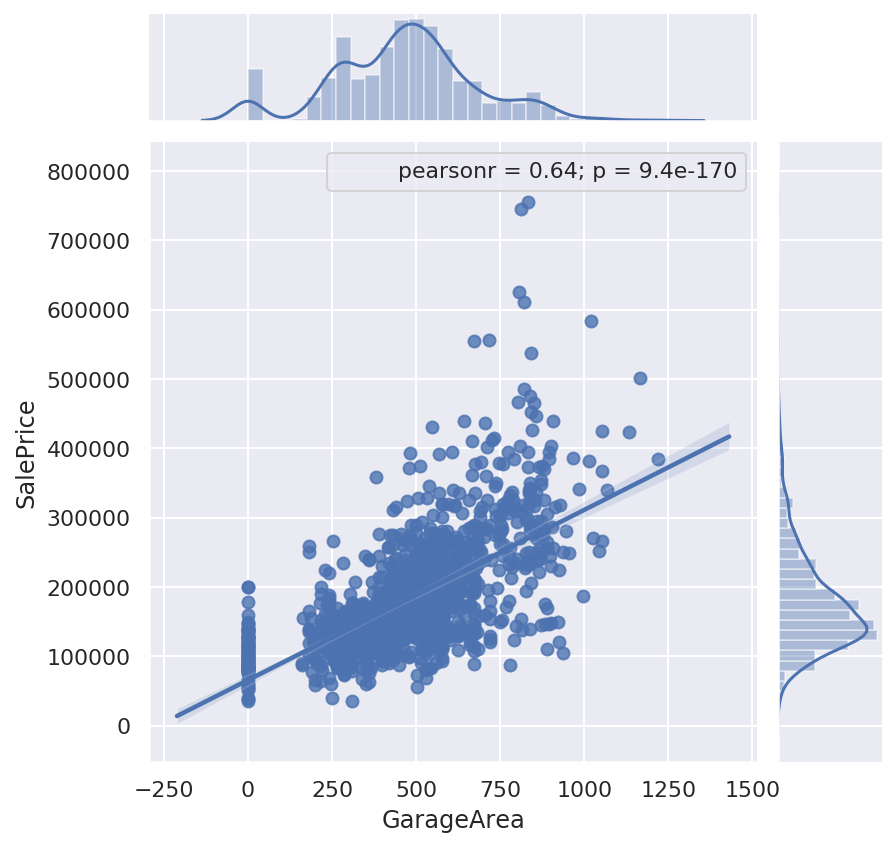

In [172]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

We increase the correlation coefficient by 0.01 point

#### TotalBsmtSF

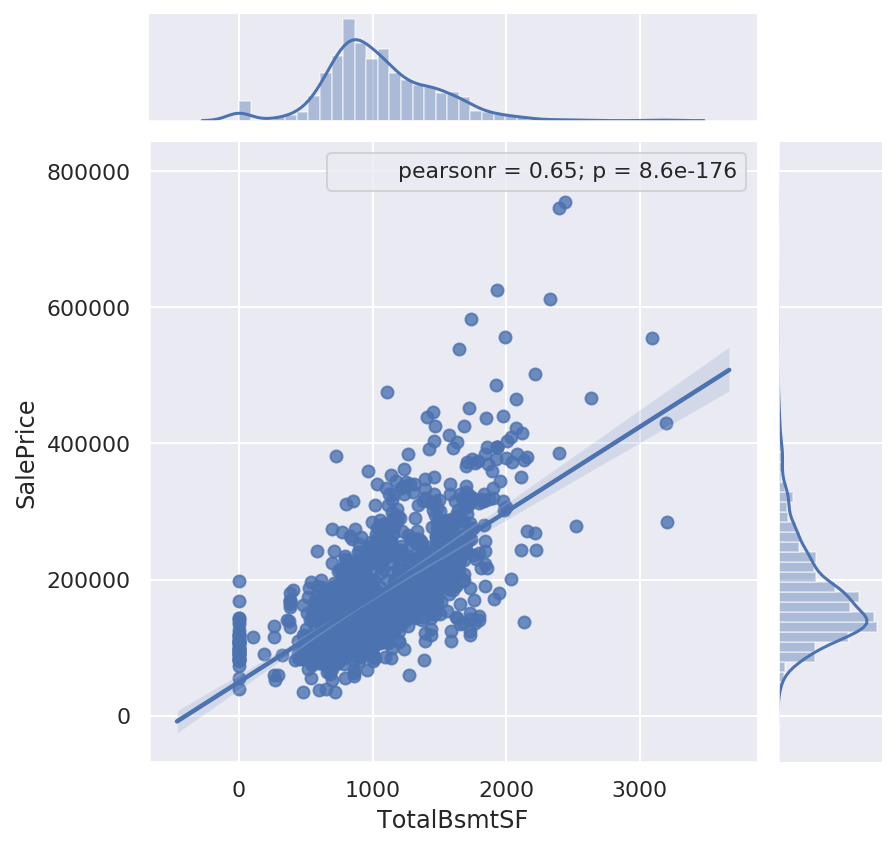

In [173]:
sns.jointplot(x=train['TotalBsmtSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

We don't see any obvious outlier value here

#### 1stFlrSF

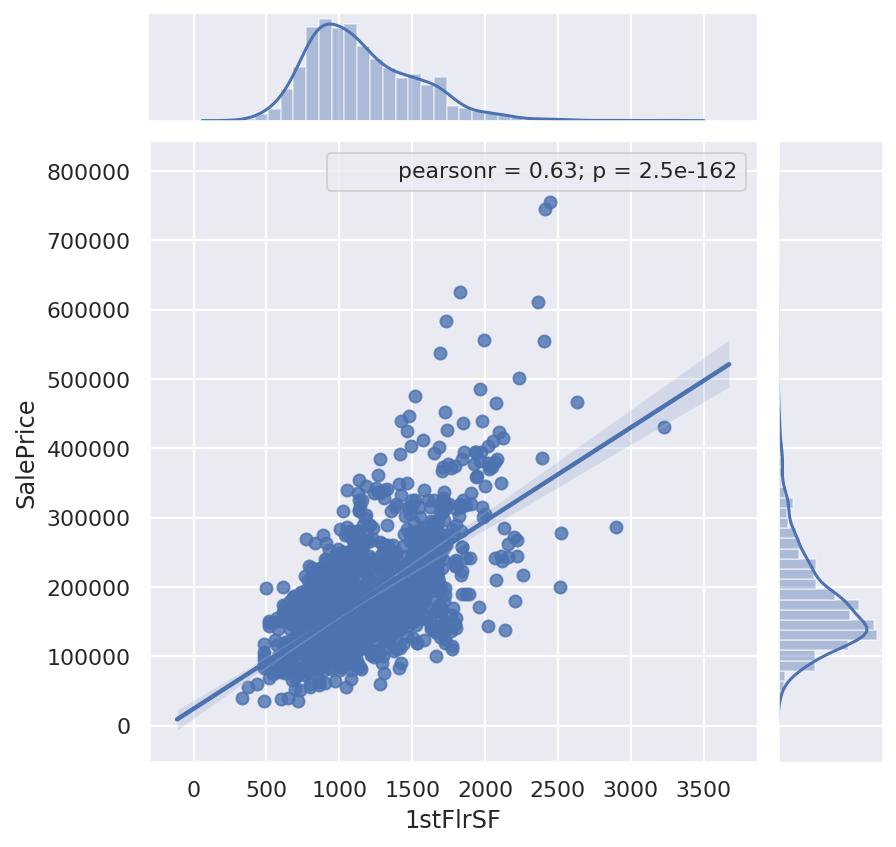

In [174]:
sns.jointplot(x=train['1stFlrSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

Nothing here

#### TotRmsAbvGrd

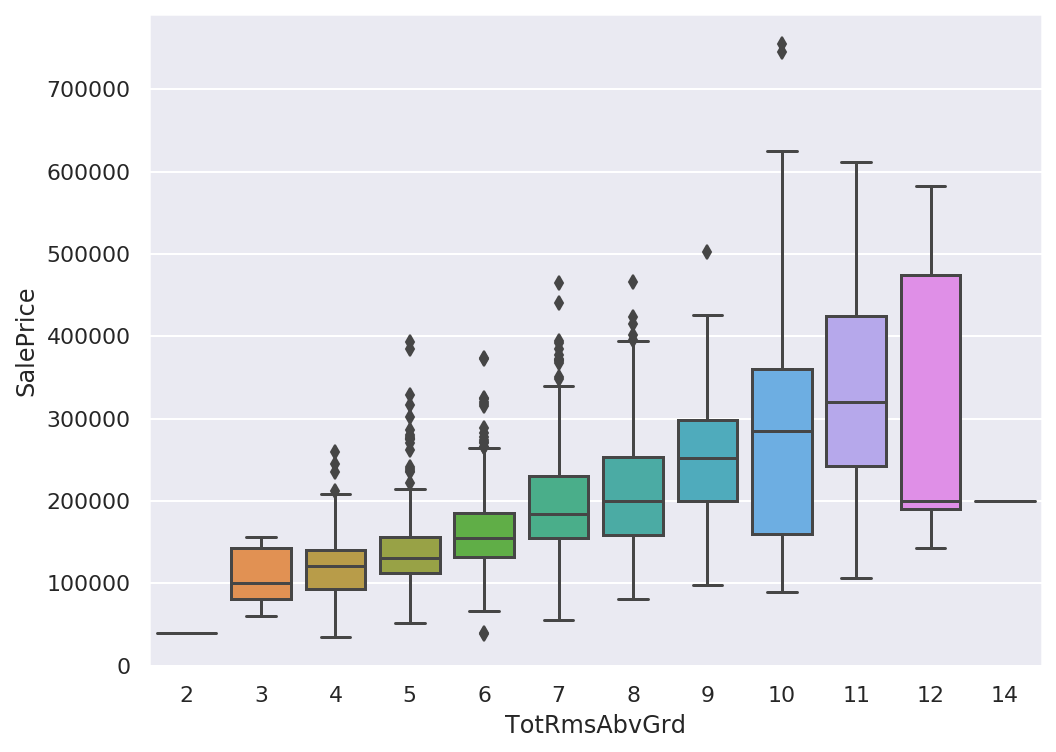

In [175]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

We can observe houses with more than 11 rooms are less expensive.  
It could be a price reduction offered by the real estate agent or an outlier.  
We will consider this as an outlier and remove those values.

In [176]:
train = train.drop(train[(train['TotRmsAbvGrd'] > 11) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

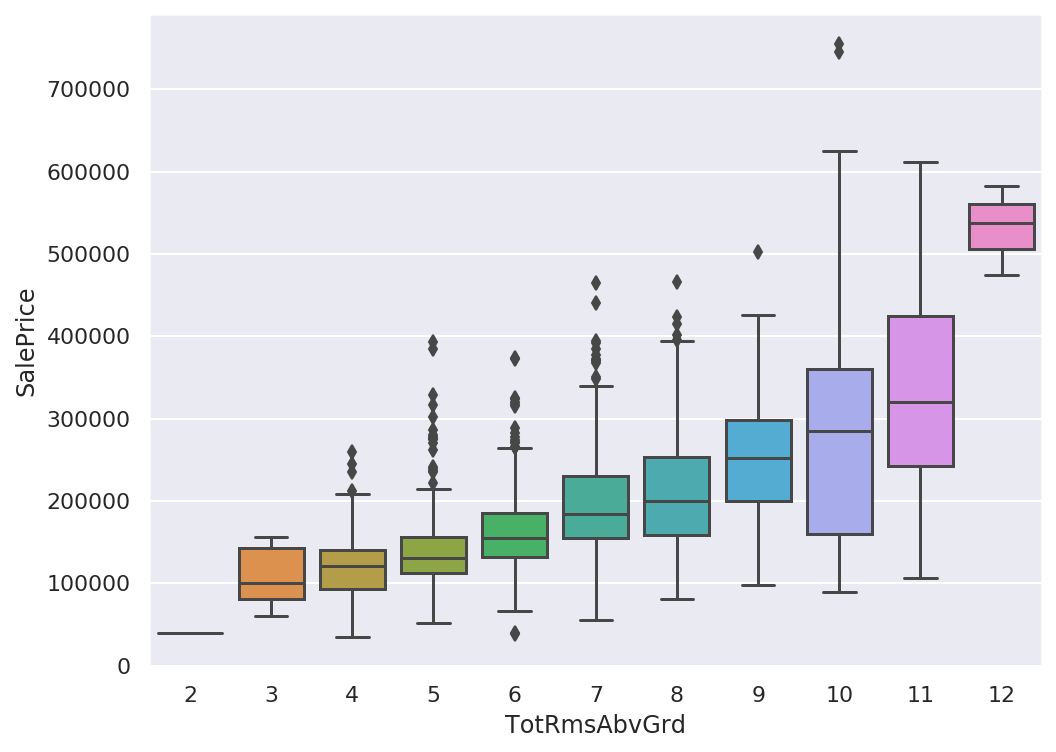

In [177]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

#### YearBuilt

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

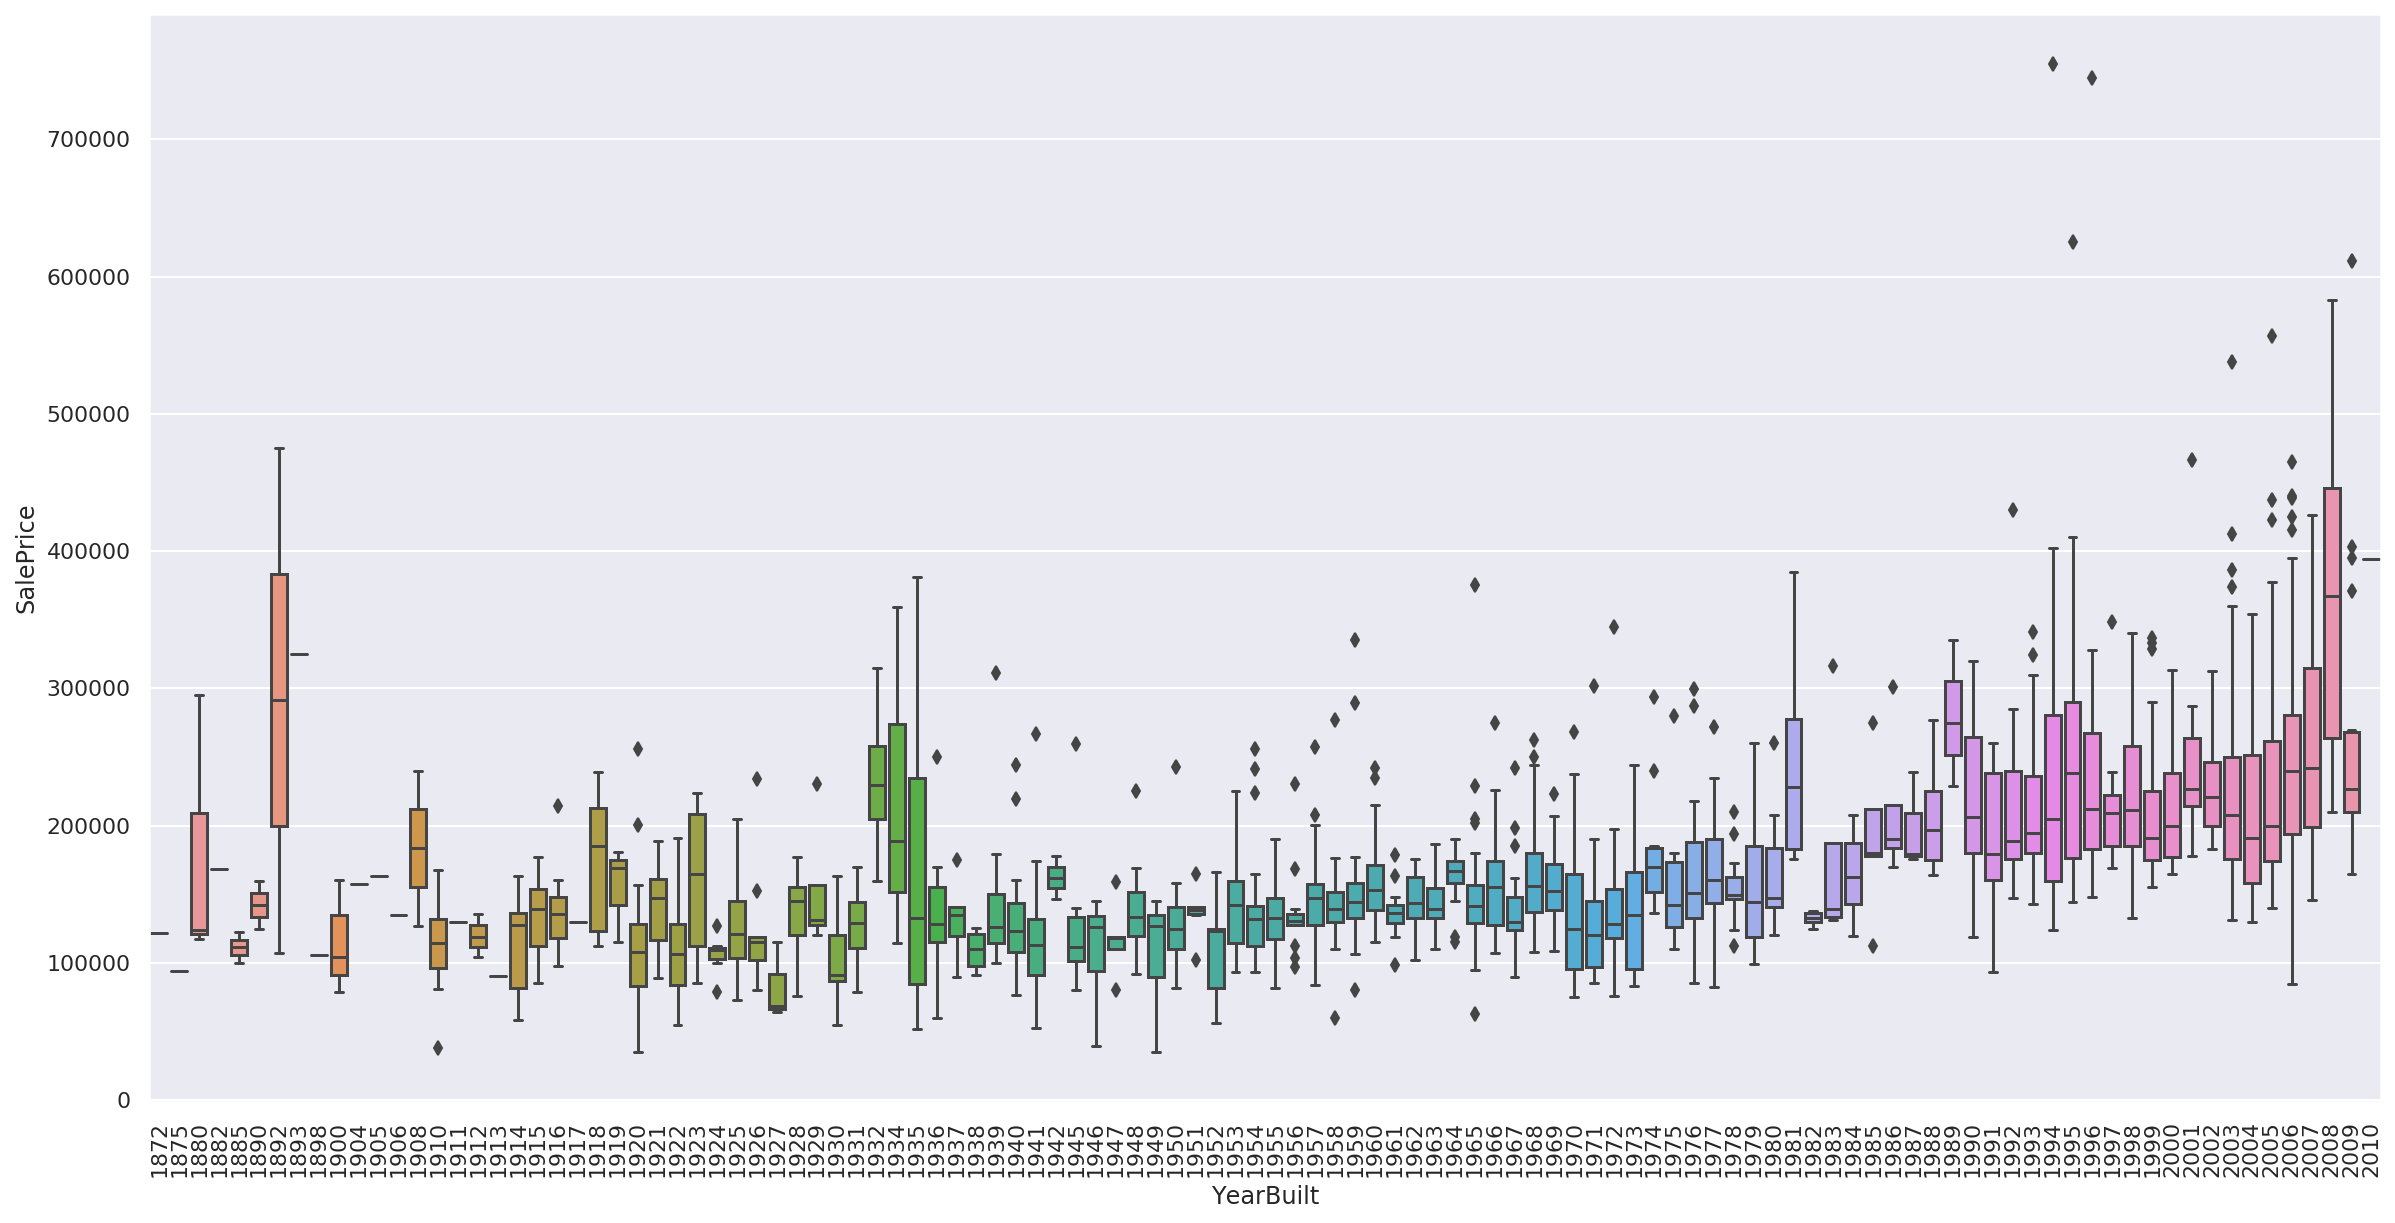

In [178]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = train['YearBuilt'], y = train['SalePrice'])
plt.xticks(rotation = 90)

We cannot be sure if the High Sale Prices are a consequence of the inflation or crisis (1929, 1973, 2008) so we don't change anything here. 

## Handle missing Data and Clean Data

Is the missing important to predict Sale Price ?  
Is missing data random or does it have a pattern ?

Let's combine train and test data into one dataset to do some cleaning

In [179]:
# Combining Datasets
rows_train = train.shape[0]
rows_test = test.shape[0]

y_train = train.SalePrice.values
y_train

combined = pd.concat((train, test)).reset_index(drop = True)
combined.drop(['SalePrice'], axis=1, inplace=True)
combined.shape

print(f"Train dataset size: {train.shape}")
print(f"Test dataset size: {test.shape}")
print(f"Combined dataset(train + test) size: {combined.shape}")

Train dataset size: (1444, 80)
Test dataset size: (1459, 79)
Combined dataset(train + test) size: (2903, 79)


Missing values ratio

In [180]:
combined_na = (combined.isnull().sum() / len(combined)) * 100
combined_na = combined_na.drop(combined_na[combined_na == 0].index).sort_values(ascending = False)
len(combined_na)

34

In [181]:
missing_data = pd.DataFrame({'Missing Values Ratio' :combined_na})
missing_data

,Missing Values Ratio
PoolQC,99.724423
MiscFeature,96.486393
Alley,93.248364
Fence,80.434034
FireplaceQu,48.673786
LotFrontage,16.672408
GarageQual,5.408198
GarageCond,5.408198
GarageFinish,5.408198
GarageYrBlt,5.408198


Vizualisation Missing Values Ratio

Text(0.5, 1.0, 'Percent missing data by feature')

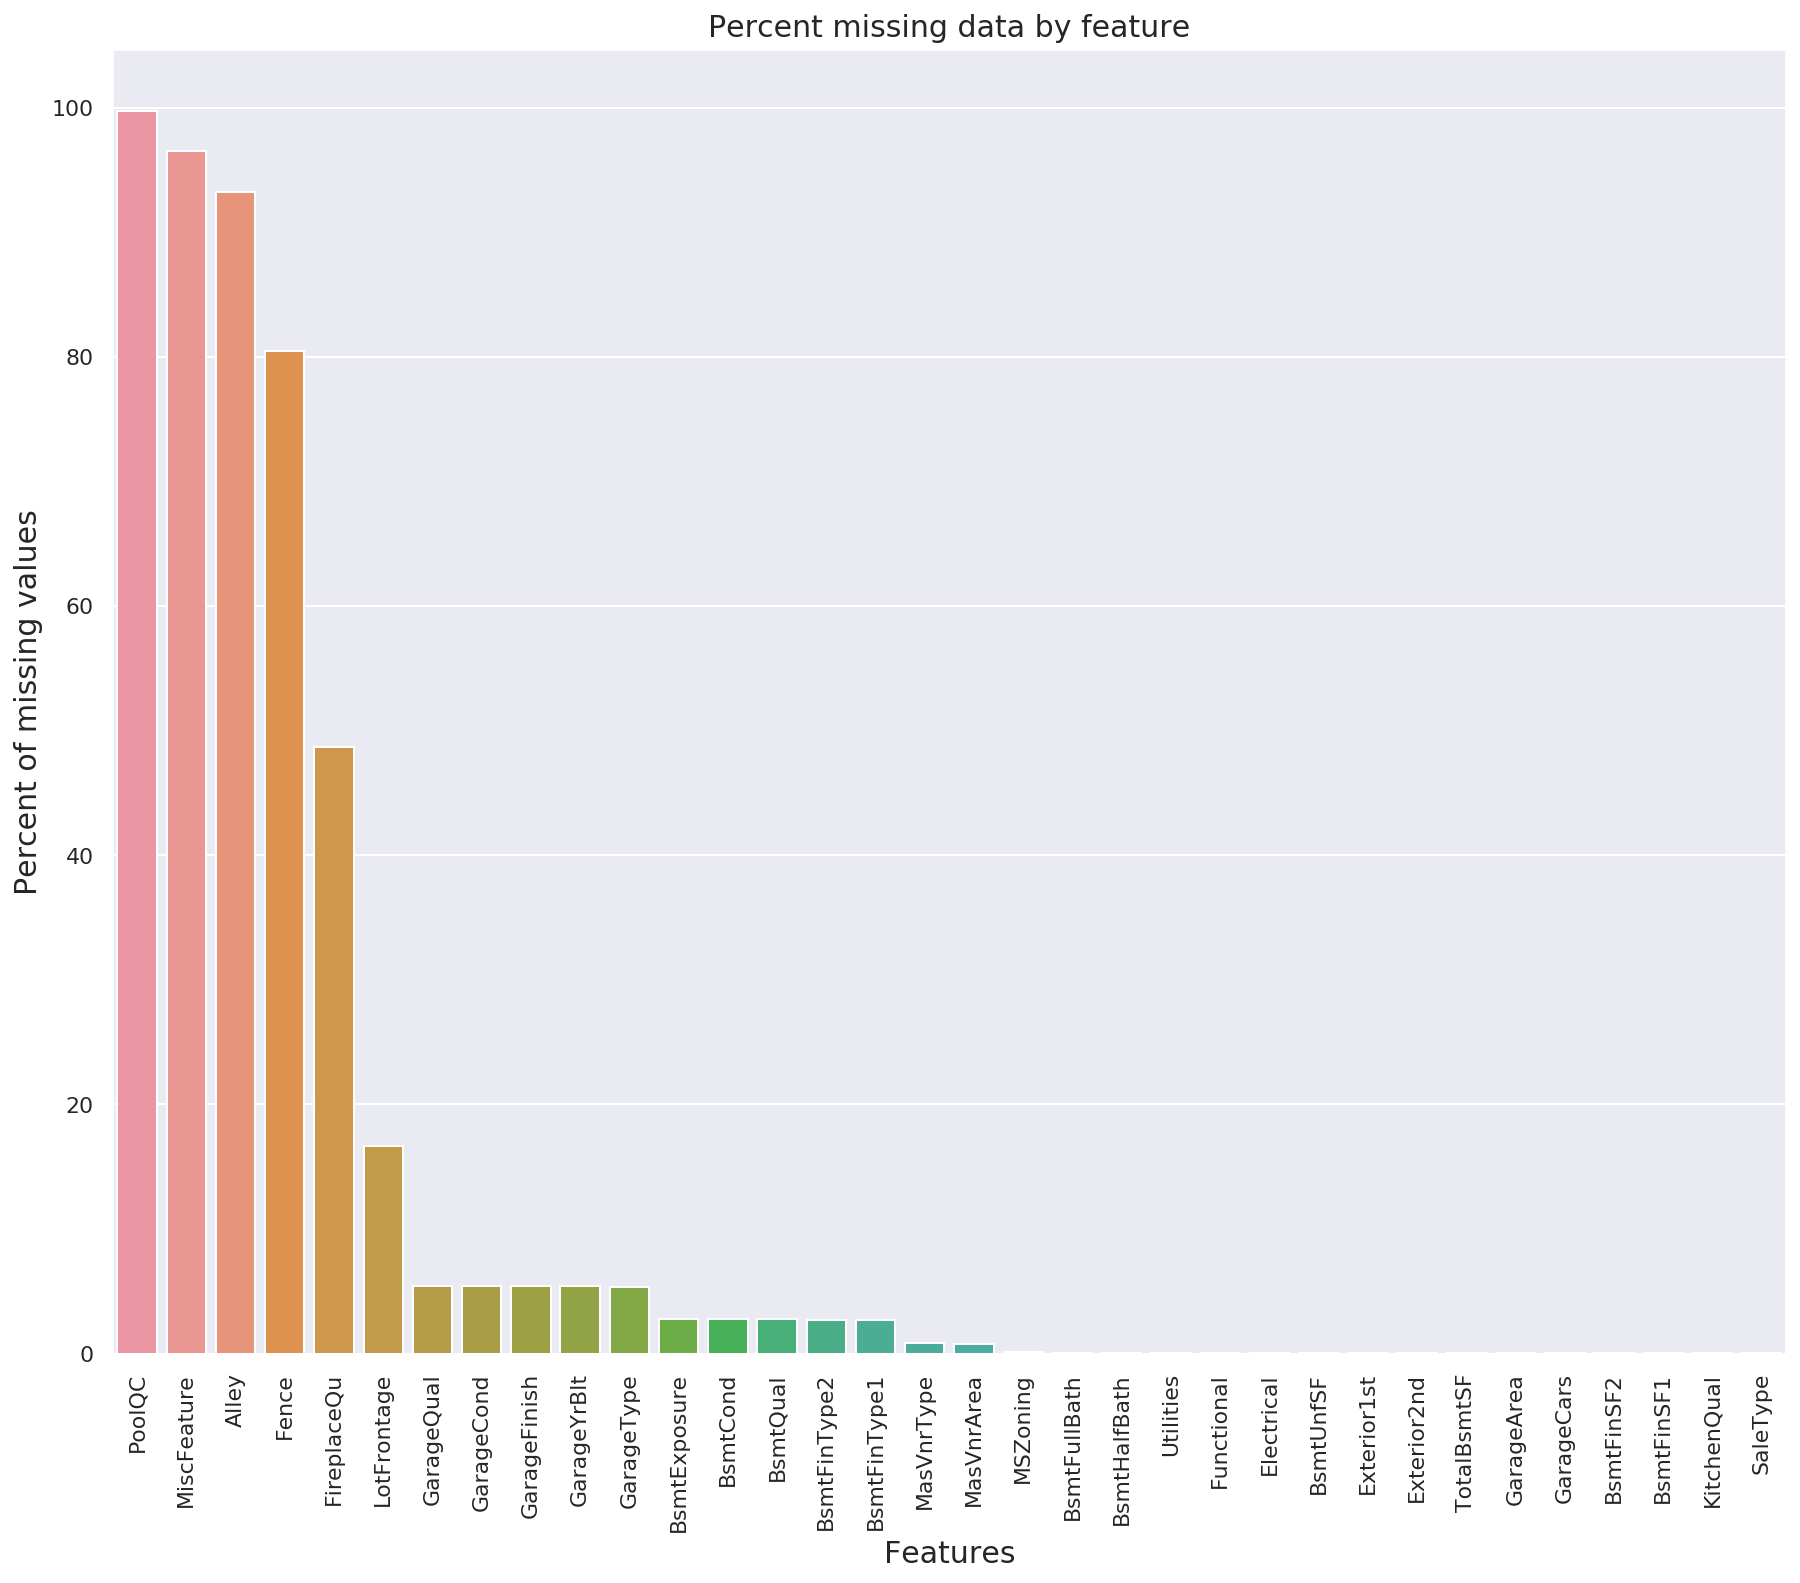

In [182]:
# Percent missing data by feature
f, ax = plt.subplots(figsize = (15, 12))
plt.xticks(rotation = '90')
sns.barplot(x = combined_na.index, y = combined_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize=15)

With the help of the description file, we can say :

* **PoolQC** : data description says NA means "No Pool"
* **MiscFeature** : data description says NA means "no misc feature"
* **Alley** : data description says NA means "no alley access"
* **Fence** : data description says NA means "no fence"
* **FireplaceQu** : data description says NA means "no fireplace"
* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with "None".
* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0.
* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: Replacing missing data with 0.
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there isn't a basement.
* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* **MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* **Functional** : data description says NA means typical.
* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* **Exterior1st and Exterior2nd **: Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* **SaleType** : Fill in again with most frequent which is "WD"
* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

Let's do this

In [183]:
combined["PoolQC"] = combined["PoolQC"].fillna("None")
combined["MiscFeature"] = combined["MiscFeature"].fillna("None")
combined["Alley"] = combined["Alley"].fillna("None")
combined["Fence"] = combined["Fence"].fillna("None")
combined["FireplaceQu"] = combined["FireplaceQu"].fillna("None")
combined["LotFrontage"] = combined.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    combined[col] = combined[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    combined[col] = combined[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    combined[col] = combined[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    combined[col] = combined[col].fillna('None')
    
combined["MasVnrType"] = combined["MasVnrType"].fillna("None")
combined["MasVnrArea"] = combined["MasVnrArea"].fillna(0)
combined['MSZoning'] = combined['MSZoning'].fillna(combined['MSZoning'].mode()[0])
combined = combined.drop(['Utilities'], axis=1)
combined["Functional"] = combined["Functional"].fillna("Typ")
combined['Electrical'] = combined['Electrical'].fillna(combined['Electrical'].mode()[0])
combined['KitchenQual'] = combined['KitchenQual'].fillna(combined['KitchenQual'].mode()[0])
combined['Exterior1st'] = combined['Exterior1st'].fillna(combined['Exterior1st'].mode()[0])
combined['Exterior2nd'] = combined['Exterior2nd'].fillna(combined['Exterior2nd'].mode()[0])
combined['SaleType'] = combined['SaleType'].fillna(combined['SaleType'].mode()[0])
combined['MSSubClass'] = combined['MSSubClass'].fillna("None")

In [184]:
combined_na = (combined.isnull().sum() / len(combined)) * 100
combined_na = combined_na.drop(combined_na[combined_na == 0].index).sort_values(ascending = False)
len(combined_na)

0

Now we don't have any missing values

### Feature Transformation

We have to change some numerical into categorical because they are code more than values. For example MSSubClass = 20 is not six times worth than MSSubClass = 120. 

In [185]:
combined['MSSubClass'] = combined['MSSubClass'].apply(str)
combined['OverallCond'] = combined['OverallCond'].astype(str)
combined['YrSold'] = combined['YrSold'].astype(str)
combined['MoSold'] = combined['MoSold'].astype(str)

For categorical features we use LabelEncoder to give numerical values to these features

In [186]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns and apply LabelEncoder to categorical features
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(combined[col].values)) 
    combined[col] = lbl.transform(list(combined[col].values))

# Check shape        
print('Shape all_data: {}'.format(combined.shape))

Shape all_data: (2903, 78)


In [187]:
combined

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,Normal,WD,0,1,8,856.0,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,Normal,WD,0,1,6,1262.0,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,Normal,WD,0,1,6,920.0,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,Abnorml,WD,0,1,7,756.0,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,Normal,WD,0,1,9,1145.0,192,2000,2000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,546,546,0,1,3,Twnhs,4,3,0.0,0.0,...,Normal,WD,0,1,5,546.0,0,1970,1970,0
2899,546,546,0,1,3,TwnhsE,4,3,252.0,0.0,...,Abnorml,WD,0,1,6,546.0,0,1970,1970,0
2900,1224,0,0,1,4,1Fam,4,3,1224.0,0.0,...,Abnorml,WD,0,1,7,1224.0,474,1960,1996,0
2901,970,0,0,1,3,1Fam,4,0,337.0,0.0,...,Normal,WD,0,1,6,912.0,80,1992,1992,0


In [188]:
# Check if MSSubClass Labelised with success
combined['MSSubClass'].unique()

array([10,  5, 11,  9,  4,  8, 15,  0,  6, 14, 13,  2, 12,  3,  7,  1])

We use log1p method from numpy (equivalent of log(1+x)) to all elements of the column to fix all of the skewed data to have a more normal distribution

In [189]:
train['SalePrice'] = np.log1p(train["SalePrice"])
train['SalePrice']

y_train = train.SalePrice.values

Vizualisation of the normal distribution

Text(0.5, 1.0, 'SalePrice distribution')

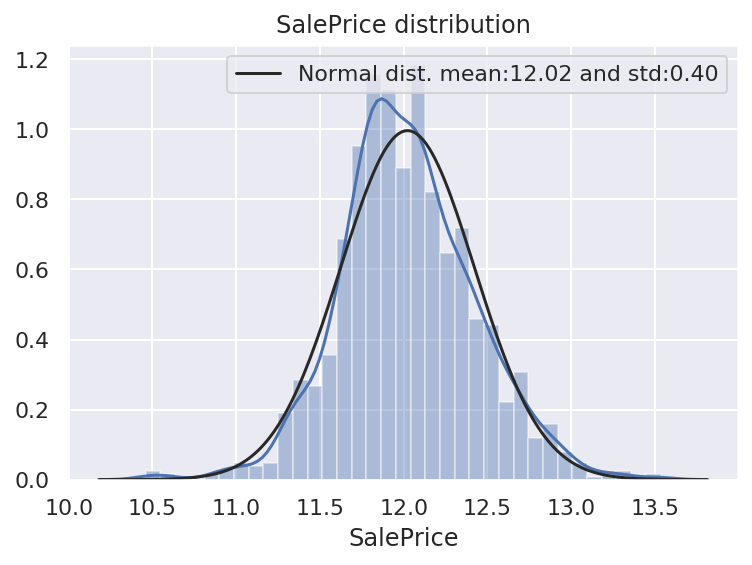

In [190]:
sns.distplot(train['SalePrice'] , fit=norm)
(mean, std) = norm.fit(train['SalePrice'])
plt.legend([f"Normal dist. mean:{mean:.2f} and std:{std:.2f}"])
plt.title('SalePrice distribution')

In [191]:
skew_combined = train['SalePrice'].skew()
kurt_combined = train['SalePrice'].kurt()

print(f"Skewness: {skew_combined}")
print(f"Kurtosis: {kurt_combined}")

Skewness: 0.12923184620175407
Kurtosis: 0.8041244099168732


In [192]:
num_features = combined.dtypes[combined.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = combined[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' :skewed_features})
skewness.head(10)

,Skewness
MiscVal,23.494165
PoolArea,18.616499
LotArea,13.166427
LowQualFinSF,12.989431
3SsnPorch,11.344148
LandSlope,4.982119
KitchenAbvGr,4.401602
BsmtFinSF2,4.156884
EnclosedPorch,4.008390
BsmtHalfBath,3.933262


We fix a threshold for skewness at 0.75

In [193]:
skewness = skewness[abs(skewness) > 0.75]
print(f"There are {skewness.shape[0]} skewed numerical features")

There are 58 skewed numerical features


#### 58 of the Numerical features will require transformation

We will use the Box-Cox Transformation on the skewed features to get a more normal dist.  
We use scipy's boxcop1p function to do this.  
We will use a value of lambda of 0.15

In [194]:
from scipy.special import boxcox1p

boxcox_features = skewness.index
lam = 0.15
for feat in boxcox_features:
    combined[feat] = boxcox1p(combined[feat], lam)
    combined[feat] += 1

### Creating dummy variables

The model we shall use accept only numbers so we have to transform strings values into numbers.  
We create dummy variable for our categorical features.  
We use pandas get_dummies method for this.

In [195]:
print(combined.shape)

(2903, 78)


In [196]:
combined = pd.get_dummies(combined)
print(combined.shape)

(2903, 217)


### Split the data again into train and test data before modelling

In [197]:
train = combined[:rows_train]
test = combined[rows_train:]

train_prepared = combined[:rows_train]
test_prepared = combined[rows_train:]

train_prepared['SalePrice'] = y_train

# Save prepared datasets
train_prepared.to_csv("train_prepared.csv")
test_prepared.to_csv("test_prepared.csv")

## Modeling

 ### Import model

In [126]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb

### Target column

In [127]:
train['SalePrice'] = y_train

### Train-test split

In [128]:
target = 'SalePrice'

train_split, val = train_test_split(train, test_size=0.3, random_state=42)

X_train = train_split.drop(target, axis=1).values
y_train = train_split[target].values
X_val = val.drop(target, axis=1).values
y_val = val[target].values

X_test = test.values

### Instantiate model class

In [129]:
# XGBRegressor
xgbr = xgb.XGBRegressor(min_child_weight= 7, 
                        max_depth= 10, 
                        learning_rate= 0.15, 
                        gamma= 0.1, 
                        colsample_bytree= 0.5,
                        random_state=42)

In [130]:
# Kernel Ridge
KRR = KernelRidge(alpha=1, 
                  kernel='polynomial', 
                  degree=2, 
                  coef0=2.5
                 )

### Train model with the fit method

In [131]:
#fit the model with train data

xgbr.fit(X_train, y_train)
KRR.fit(X_train, y_train)

[13:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KernelRidge(alpha=1, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
            kernel_params=None)

### Predicting and checking the results

#### Cross-validation method

In [132]:
# Check the model accuracy with cross-validation method

# XGBR
scores_xgbr = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score XGBoost: %.2f" % scores_xgbr.mean())

# KRR
scores_krr = cross_val_score(KRR, X_train, y_train, cv=5)
print("Mean cross-validation score Kernel Ridge: %.2f" % scores_krr.mean())

# Cross-validation with a k-fold method
#kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
#print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

[13:13:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score XGBoost: 0.89
Mean cross-validation score Kernel Ridge: 0.91


The model is around 90 %  accurate on average.  
Next, we can predict test data and check its accuracy.  
Here, we'll use MSE and RMSE as accuracy metrics.

#### Predictions

In [133]:
y_pred_xgbr = xgbr.predict(X_val)
mse_xgbr = mean_squared_error(y_val, y_pred_xgbr)
print("MSE XGBR: %.4f" % mse_xgbr)
print("RMSE XGBR: %.4f" % np.sqrt(mse_xgbr))

MSE XGBR: 0.0154
RMSE XGBR: 0.1242


In [134]:
y_pred_krr = KRR.predict(X_val)
mse_krr = mean_squared_error(y_val, y_pred_krr)
print("MSE Kernel Ridge: %.4f" % mse_krr)
print("RMSE Kernel Ridge: %.4f" % np.sqrt(mse_krr))

MSE Kernel Ridge: 0.0135
RMSE Kernel Ridge: 0.1163


#### SalePrice real values

In [67]:
y_kaggle_xgbr = np.expm1(xgbr.predict(X_test))
y_kaggle_krr = np.expm1(KRR.predict(X_test))

## Submission

In [ ]:
import kaggle

kaggle_feats = {'Id':test_id, 'SalePrice':y_kaggle}
sub = pd.DataFrame(data=kaggle_feats)
sub.to_csv('submission_krr.csv', index=False)

submission_file = 'submission_krr.csv'
kaggle.api.competition_submit(submission_file, "Submission KRR)", "house-prices-advanced-regression-techniques")

In [ ]:
def submit_kaggle(model):
    kaggle_feats = {'Id':test_id, 'SalePrice':y_kaggle_{model}}
    sub = pd.DataFrame(data=kaggle_feats)
    sub.to_csv('submission_{}.csv'.format(model), index=False)

    submission_file = 'submission_{}.csv'.format(model)
    kaggle.api.competition_submit(submission_file, "Submission {}".format(model), "house-prices-advanced-regression-techniques")
    